#### Useful imports and extensions

In [1]:
import jsonlines
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#from pyspark import SparkContext
import numpy as np
import json
import plotly.express as px
from plotly import graph_objects as go
from tqdm import tqdm

#from classify_google_utils import classify_all

%load_ext autoreload

## Loading dataset and extracting climate change related videos

We want to study youtube videos related to climate change : the first step is to filter our broad dataset of all videos.
For this, we generated a list of keywords related to climate change :

In [157]:
with open('keywords.json') as f:
    keywords = json.load(f)['keywords']

We create functions to check if a video contains climate change related keywords in its title, description or tags

In [ ]:
def about_climate(tags):
    tags_set = set(tags)
    return any(tag.strip().lower() in keywords for tag in tags_set)

def climate_text(text):
    lowercase_text = text.lower()
    return any(keyword in lowercase_text for keyword in keywords)

def climate_related(video):
    return (climate_text(video['title']) or about_climate(video['tags']) or climate_text(video['description']))

Since the original video metadata dataset is huge (97 GB), we read and filter the dataset using pyskark in order to get a reduced dataset with only the relevant videos.

### Load the dataset

In [ ]:
path_to_disk = '/Volumes/Maxtor'
file_path = '/yt_metadata_en.jsonl'

sc = SparkContext()
raw_data = sc.textFile(path_to_disk + file_path)
video_dataset = raw_data.map(lambda x: json.loads(x))

### Filter the dataset

In [ ]:
climate_videos = video_dataset.filter(climate_related)
climate_videos_collected = climate_videos.collect()

In [ ]:
climate_videos_path = "data/coarse_filter_climate_videos.jsonl"
with jsonlines.open(climate_videos_path, "w") as jsonl_file:
   jsonl_file.write_all(climate_videos_collected)

#### Sample dataset

We create 2 random sample dataset (1% ands 0.1%) which may be useful later in our analysis for statisitical comparison with the cliamte related videos dataset.

In [ ]:
seed = 42

random_sample_1percent = video_dataset.sample(False, 0.01, seed=seed)
random_sample_1percent_collected = random_sample_1percent.collect()
sample_1percent_path = "data/sample_1percent.jsonl"
with jsonlines.open(sample_1percent_path, "w") as jsonl_file:
    jsonl_file.write_all(random_sample_1percent_collected)


random_sample_01percent = video_dataset.sample(False, 0.001, seed=seed)
random_sample_01percent_collected = random_sample_01percent.collect()
sample_01percent_path = "data/sample_01percent.jsonl"
with jsonlines.open(sample_01percent_path, "w") as jsonl_file:
    jsonl_file.write_all(random_sample_01percent_collected)


In [ ]:
sc.stop()

### Extracting useful features from the whole dataset

We keep working on the whole dataset in order to extract useful features which may be useful later for comparison purpose. We use the .feather helper for this. 

In [2]:
feather_path = "data/yt_metadata_helper.feather"
video_dataset_feather = pd.read_feather(feather_path)

In [12]:
video_count_by_date_cat = video_dataset_feather.groupby(['upload_date', 'categories']).size().reset_index(name='count')
video_count_by_date_cat['upload_date'] = video_count_by_date_cat['upload_date'].dt.strftime('%Y-%m-%d')
video_count_by_date = video_count_by_date_cat[['upload_date', 'count']].groupby(['upload_date']).sum().reset_index()
video_count_by_cat = video_count_by_date_cat[['categories', 'count']].groupby(['categories']).sum().reset_index()
nb_videos = video_dataset_feather.shape[0]
print(f"Number of videos: {nb_videos}")

Number of videos: 72924794


In [9]:
video_count_by_date_cat.to_json("data/nb_videos_by_date_cat.jsonl", orient="records", lines=True)
video_count_by_date.to_json("data/nb_videos_by_date.jsonl", orient="records", lines=True)
video_count_by_cat.to_json("data/nb_videos_by_cat.jsonl", orient="records", lines=True)

### Filtering refinment

In [4]:
coarse_filter_climate_videos_path = "data/climate_videos.jsonl" 
coarse_filter_climate_videos = pd.read_json(coarse_filter_climate_videos_path, lines=True)
nb_coarse_climate_videos = coarse_filter_climate_videos.shape[0]
print(f"Number of climate related videos {nb_coarse_climate_videos}")

Number of climate related videos 145008


Even though we filtered out a lot of videos, we still observed several non climate related videos. Hence we have to perform a beter filtering. Having much less data allows us to use a much more costly but more accurate filtering method: using an NLP classifier. We use the google content classifier.

### Classifying videos using google content classifier

In [ ]:
google_credentials_path = "silent-circlet-407818-8bcb92199b3e.json"
classified_coarse_filter_climate_videos_df = classify_all(video_dataframe=coarse_filter_climate_videos, credentials_path=google_credentials_path)

In [ ]:
classified_path = "data/climate_videos_sample_classified.jsonl"
classified_coarse_filter_climate_videos_df.to_json(classified_path, orient="records", lines=True)

Now that we could give more categories to each videos, we will use these to filter out more videos

### Further filtering using the google classification
We do a second filtering to keep only videos that contain at least one climate-related category according to Google content classifier.

First we define the list of climate-related categories, and then we filter the dataframe with it.

In [ ]:
most_common_categories = classified_coarse_filter_climate_videos_df['classification_categories'].explode().unique()
# remove nan and non category values
most_common_categories = [category for category in most_common_categories 
                          if isinstance(category, str) and category.startswith('/')]

In [ ]:
climate_related_categories = []

# Filter categories with the keywords
for cat in most_common_categories:
    if any(keyword in cat for keyword in keywords):
        climate_related_categories.append(cat)

# Manualy remove non relevant ones
climate_related_categories.remove('/News/Business News/Economy News')
climate_related_categories.remove('/People & Society/Social Sciences/Economics')
climate_related_categories.remove('/Health/Health Conditions/Allergies/Environmental Allergies')

In [ ]:
climate_related_categories

['/People & Society/Social Issues & Advocacy/Green Living & Environmental Issues',
 '/Science/Ecology & Environment/Other',
 '/Science/Ecology & Environment/Climate Change & Global Warming',
 '/Business & Industrial/Energy & Utilities/Renewable & Alternative Energy',
 '/Shopping/Green & Eco-Friendly Shopping',
 '/Travel & Transportation/Specialty Travel/Ecotourism']

In [ ]:
df = classified_coarse_filter_climate_videos_df[classified_coarse_filter_climate_videos_df['classification_categories']
                                        .apply(lambda x: any(category in x.keys() for category in climate_related_categories))]

In [ ]:
df.to_json('climate_videos_v3.jsonl', orient='records', lines=True)

We finally export the double-filtered dataframe in a jsonl file:

In [5]:
final_filter_climate_videos_path = "data/climate_videos_v3.jsonl"
climate_videos_df = pd.read_json(final_filter_climate_videos_path, lines=True)
nb_climate_videos = climate_videos_df.shape[0]

The filtering steps result in:

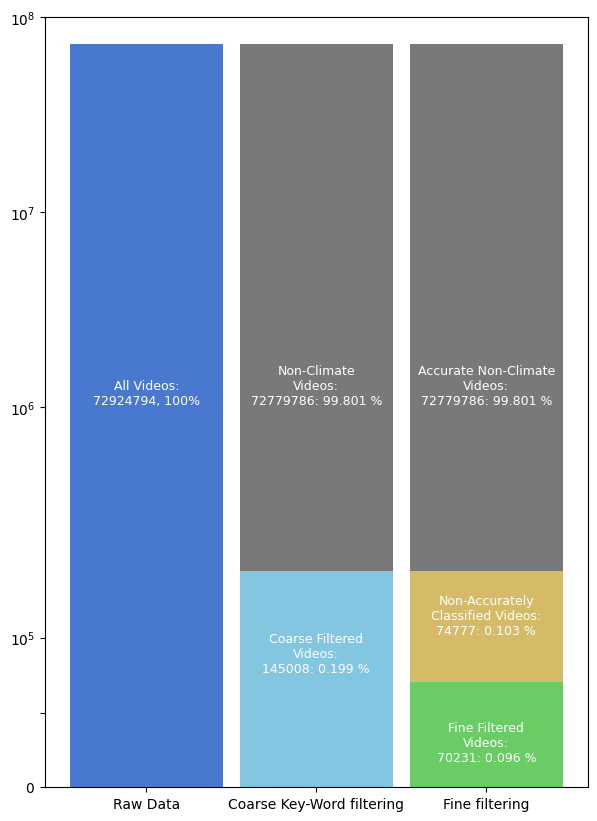

In [153]:
STEPS = ('Raw Data', 'Coarse Key-Word filtering', 'Fine filtering')
COLORS = sns.color_palette("muted")
WIDTH = 0.9
FIG_SIZE = (7, 10)
FONT_SIZE = 9

nb_videos_plotting = nb_videos
non_climate_videos = nb_videos_plotting - nb_coarse_climate_videos
non_accurately_classified = nb_coarse_climate_videos - nb_climate_videos
accurate_non_climate_videos = nb_videos_plotting - nb_climate_videos - non_accurately_classified

weight_counts = {
    "Below": ([nb_videos_plotting, nb_coarse_climate_videos, nb_climate_videos], [COLORS[0], COLORS[9], COLORS[2]]),
    "Middle": ([0, non_climate_videos, non_accurately_classified], [COLORS[0], COLORS[7], COLORS[8]]),
    "Above": ([0, 0, accurate_non_climate_videos], [COLORS[0], COLORS[7], COLORS[7]])
}

# Plotting
fig, ax = plt.subplots(figsize=FIG_SIZE)
bottom = np.zeros(3)

for boolean, (weight_count, color) in weight_counts.items():
    ax.bar(STEPS, weight_count, WIDTH, label=boolean, bottom=bottom, color=color)
    bottom += weight_count


plt.yscale('symlog', linthresh=nb_coarse_climate_videos*1)
plt.yticks(ticks=list(range(0, nb_coarse_climate_videos, 50000)) + [10**i for i in range(6, 9)])

annotations = [
    (0, 1000000, f"All Videos:\n{nb_videos_plotting}, 100%"),
    (1, 75000, f"Coarse Filtered\nVideos:\n{nb_coarse_climate_videos}: {nb_coarse_climate_videos/nb_videos*100:.3f} %"),
    (2, 15000, f"Fine Filtered\nVideos:\n{nb_climate_videos}: {nb_climate_videos/nb_videos*100:.3f} %"),
    (1, 1000000, f"Non-Climate\nVideos:\n{non_climate_videos}: {non_climate_videos/nb_videos*100:.3f} %"),
    (2, 100000, f"Non-Accurately\nClassified Videos:\n{non_accurately_classified}: {non_accurately_classified/nb_videos*100:.3f} %"),
    (2, 1000000, f"Accurate Non-Climate\nVideos:\n{accurate_non_climate_videos}: {accurate_non_climate_videos/nb_videos*100:.3f} %")
]

for x, y, text in annotations:
    ax.text(x, y, text, ha='center', va='bottom', color='white', fontsize=FONT_SIZE)

plt.show()

In [36]:
zoom = 500000
x_range = [-zoom, zoom]
fig = go.Figure(go.Funnel(
    y = ["Raw Data", "Data After Coarse filter", "Final Filtered Data"],
    x = [72924794, nb_coarse_climate_videos, nb_climate_videos],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat", "blue", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}}),
    )
fig.update_layout(xaxis=dict(range=[-zoom, zoom]))

fig.show()